In [2]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import pandas_datareader as pdr
from pandas.util.testing import assert_frame_equal
from pykrx import stock
import matplotlib.pyplot as plt


In [4]:
# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.7):
  dataset = stock.get_market_ohlcv_by_date("".join(start.split('-')), "".join(end.split('-')), stock_name.split('.KR')[0])
  dataset['Close'] = dataset['종가']
  date_split = str(dataset.index[int(train_ratio*len(dataset))])

  return dataset[:date_split], dataset[date_split:], date_split

# 야후 금융에서 조회하여 train, test로 나눔
def dataset_loader(stock_name, start, end, train_ratio=0.7):
  dataset = pdr.DataReader(stock_name, data_source="yahoo", start=start, end=end)
  date_split = str(dataset.index[int(train_ratio*len(dataset))]).split(' ')[0]

  return dataset[:date_split], dataset[date_split:], date_split

In [20]:
# 국내면 뒤에 .KR을 붙이세여
CODE = 'MRNA'
START_DATE = '2019-09-01'
END_DATE = '2020-05-29'
TRAIN_RATIO = 0.8

if '.KR' == CODE[-3:]:
    (train, test, date_split) = dataset_loaderKR(CODE, START_DATE, END_DATE, TRAIN_RATIO)
else:
    (train, test, date_split) = dataset_loader(CODE, START_DATE, END_DATE, TRAIN_RATIO)

print("test from", date_split)


test from 2020-04-03


In [15]:
# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()

    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0

        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # set next time
        self.t += 1

        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done



In [9]:
# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [27]:
# 학습 시키기
env = Environment1(train)
env.reset()

hidden_size = 100
input_size = env.history_t+1
output_size = 3
USE_CUDA = False
LR = 0.001

Q = Q_Network(input_size, hidden_size, output_size)
Q_ast = copy.deepcopy(Q)

if USE_CUDA:
    Q = Q.cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

epoch_num = 50
step_max = len(env.data)-1
memory_size = 200
batch_size = 50
gamma = 0.97

obs, reward, done = env.step(5)

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
show_log_freq = 5

start = time.time()
for epoch in range(epoch_num):
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:
        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
    print("Epoch %d" % (epoch+1))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [28]:
# TEST
test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

In [29]:
# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]

print( )
print( test )
print( )
print( CODE, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )

if next_action == 2:
	print('오늘은 매도!')
elif next_action == 1:
	print('오늘은 매수!')
else:
	print('오늘은 쉬어요!')



                 High        Low       Open      Close    Volume  Adj Close  \
Date                                                                          
2020-04-03  35.660000  32.720001  32.810001  34.840000  16896200  34.840000   
2020-04-06  35.185001  33.330002  34.910000  34.639999  10841600  34.639999   
2020-04-07  34.029999  30.980000  33.810001  32.020000  10104300  32.020000   
2020-04-08  32.939999  31.750000  32.360001  32.419998   4119800  32.419998   
2020-04-09  32.919998  31.320000  32.549999  31.860001   4861800  31.860001   
2020-04-13  32.980000  31.709999  32.000000  32.900002   5603900  32.900002   
2020-04-14  34.990002  33.150002  34.000000  34.660000   8126900  34.660000   
2020-04-15  38.450001  33.720001  34.639999  37.250000  15683000  37.250000   
2020-04-16  41.549999  36.619999  38.074001  40.599998  20670700  40.599998   
2020-04-17  49.000000  43.380001  48.990002  46.849998  32286000  46.849998   
2020-04-20  54.950001  44.509998  45.000000  51.689

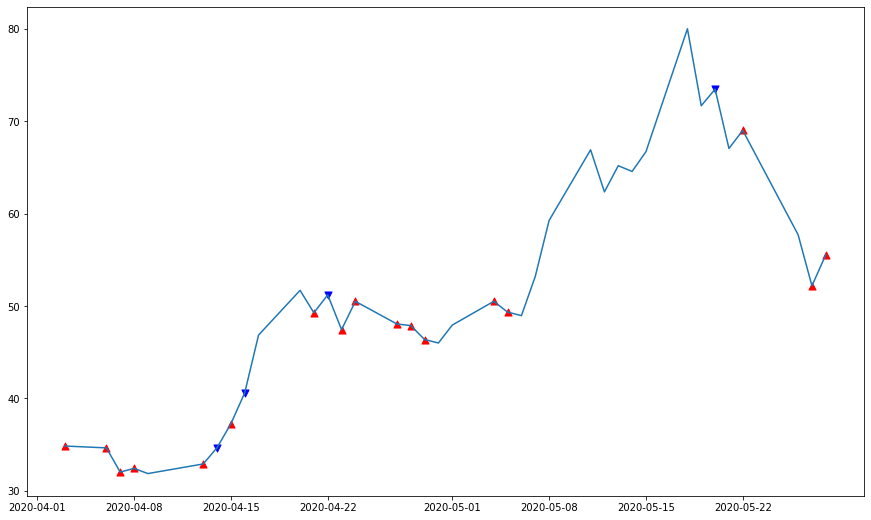

In [30]:

buy_dates = test.loc[test['Action'] ==1].index.values
sell_dates = test.loc[test['Action'] ==2].index.values

buy_close = test.loc[test['Action'] ==1, 'Close'].values
sell_close = test.loc[test['Action'] ==2, 'Close'].values

fig = plt.figure(figsize=(15,9))

plt.plot(test['Close'])
plt.scatter(buy_dates, buy_close, label='skitscat', color='red', s=50, marker="^")
plt.scatter(sell_dates, sell_close, label='skitscat', color='blue', s=50, marker="v")
plt.show()